<H1>Testing inhibitory motifs</H1>

In [1]:
# loading python modules
import numpy as np
from matplotlib.pyplot import figure
from terminaltables import AsciiTable 

from __future__ import division

In [2]:
# loading custom inet modules
from inet import DataLoader
from inet.motifs import iicounter
from inet.utils import chem_squarematrix, elec_squarematrix

In [3]:
# use the dataset to create the null hypothesis
mydataset = DataLoader('../data')

 161 syn  files loaded


<H2>Collect number of experiments </H2>

In [4]:
# e.g. mydataset.PV[2].values  will return the different configurations with 2 PV cells
nPV = range(9)
for i in nPV:
    nPV[i] = np.sum(mydataset.PV[i].values())
    nPV[i] = np.sum(mydataset.PV[i].values())

In [5]:
nPV

[0, 141, 18, 2, 0, 0, 0, 0, 0]

In [6]:
# for the moment, we only count experiments with 2 or 3 PVs
# later we use mydataset.PV[2:]
PV2 = sum(mydataset.PV[2].values())
PV3 = sum(mydataset.PV[3].values())
PV2, PV3

(18, 2)

<H2> Calculate empirical probabilities </H2>

In [7]:
PC = mydataset.II_chem_found/mydataset.II_chem_tested
PE = mydataset.II_elec_found/mydataset.II_elec_tested
PC2  = mydataset.II_c2_found/mydataset.II_c2_tested

PC1E = mydataset.II_c1e_found/mydataset.II_c1e_tested
PC2E = mydataset.II_c2e_found/mydataset.II_c2e_tested


info = [
    ['key', 'Probability', 'Motif', 'Value'],
    ['ii_chem', 'P(C)', 'chemical synapse',PC ],
    ['ii_elec', 'P(E)', 'electrical synapse',PE ],
    ['','',''],
    ['c2', 'P(C U C)','bidirectional chemical synapse',PC2],
    ['c1e', 'P(C U E)', 'electrical and unidirectional chemical', PC1E],
    ['c2e', 'P(2C U E):','electrical and bidirectional chemical', PC2E],

]
print(AsciiTable(info).table)

+---------+-------------+----------------------------------------+----------------+
| key     | Probability | Motif                                  | Value          |
+---------+-------------+----------------------------------------+----------------+
| ii_chem | P(C)        | chemical synapse                       | 0.291666666667 |
| ii_elec | P(E)        | electrical synapse                     | 0.458333333333 |
|         |             |                                        |                |
| c2      | P(C U C)    | bidirectional chemical synapse         | 0.166666666667 |
| c1e     | P(C U E)    | electrical and unidirectional chemical | 0.145833333333 |
| c2e     | P(2C U E):  | electrical and bidirectional chemical  | 0.125          |
+---------+-------------+----------------------------------------+----------------+


<H2> Simulate random chemical synapses</H2>
from a random distribution whose probability is adjusted to the empirical probability found in the recordings.


In [8]:
def mychem_simulation():
    """
    simulate inhibitory chemical connections of the dataset
    
    Return
    ------
    A iicounter object 
    """
    mycount = iicounter()
    for _ in range(PV2):
        mycount += iicounter(chem_squarematrix(size=2,prob = PC))

    for _ in range(PV3):
        mycount += iicounter(chem_squarematrix(size=3, prob = PC))
        
    return(mycount)

In [9]:
mychem_simulation() # one simulation, test the number of connection tested

{'ii_c1e': {'found': 0, 'tested': 48},
 'ii_c2': {'found': 1, 'tested': 24},
 'ii_c2e': {'found': 0, 'tested': 24},
 'ii_chem': {'found': 15, 'tested': 48},
 'ii_elec': {'found': 0, 'tested': 24}}

In [10]:
# must contain the same number of tested connections
for key in mychem_simulation().keys():
    print(key, mydataset.motif[key])

('ii_c1e', {'tested': 48, 'found': 7})
('ii_elec', {'tested': 24, 'found': 11})
('ii_c2', {'tested': 24, 'found': 4})
('ii_c2e', {'tested': 24, 'found': 3})
('ii_chem', {'tested': 48, 'found': 14})


In [11]:
# simulate the whole data set 10,000 times
n_chem = list()
n_bichem = list()
for _ in range(1000):
    syn_counter = mychem_simulation()
    n_chem.append(syn_counter['ii_chem']['found'])
    n_bichem.append(syn_counter['ii_c2']['found'])

If the null hypothesis is correctly implemented, we should see almost the same 
number of chemical synases as in the experiments.

In [12]:
np.mean(n_chem) # on average 14 unidirectional connections


13.94

In [13]:
mydataset.motif['ii_chem']['found']

14

If we found a number which is different form the empirical, we must revise our 
null hypothese.

In [14]:
np.mean(n_bichem) # on average two

1.9990000000000001

Define analiticaly the null hypothese:

In [15]:
PC*PC*mydataset.motif['ii_c2']['tested'] # null hypothesis

2.041666666666667

In [16]:
mydataset.motif['ii_c2']['found'] # however, we found more empirically

4

<H2> Simulate random electrical synapses</H2>
from a random distribution whose probability is adjusted to the empirical probability found in the recordings.

In [17]:
def myelec_simulation():
    """
    simulate inhibitory electrical connections of the dataset
    
    Return
    ------
    A iicounter object 
    """
    mycount = iicounter()
    for _ in range(PV2):
        mycount += iicounter(elec_squarematrix(size=2,prob = PE))

    for _ in range(PV3):
        mycount += iicounter(elec_squarematrix(size=3, prob = PE))
        
    return(mycount)

In [18]:
myelec_simulation() # one simulation, test the number of connection tested

{'ii_c1e': {'found': 0, 'tested': 48},
 'ii_c2': {'found': 0, 'tested': 24},
 'ii_c2e': {'found': 0, 'tested': 24},
 'ii_chem': {'found': 0, 'tested': 48},
 'ii_elec': {'found': 9, 'tested': 24}}

In [19]:
# must contain the same number of tested connections
for key in myelec_simulation().keys():
    print(key, mydataset.motif[key])

('ii_c1e', {'tested': 48, 'found': 7})
('ii_elec', {'tested': 24, 'found': 11})
('ii_c2', {'tested': 24, 'found': 4})
('ii_c2e', {'tested': 24, 'found': 3})
('ii_chem', {'tested': 48, 'found': 14})


In [20]:
n_elec = list()
for _ in range(1000):
    syn_elec = myelec_simulation()
    n_elec.append(syn_elec['ii_elec']['found'])

Similarly, we must see almost the same 
number of electrical connections as with the experiments

In [21]:
np.mean(n_elec)

10.881

In [22]:
mydataset.motif['ii_elec']['found'] # voila!

11

<H2>Simulate electrical and chemical synapses independently</H2>

In [23]:
C = chem_squarematrix(size = 2, prob = PC)
E = elec_squarematrix(size = 2, prob = PE)
C + E # when a chemical (1) and electrical (2) synapse add , they have the motif 3

array([[0, 0],
       [0, 0]])

In [24]:
def myii_simulation():
    """
    simulate inhibitory electrical and chemical connections of the dataset
    
    Return
    ------
    A iicounter object 
    """
    mycount = iicounter()
    for _ in range(PV2):
        C = chem_squarematrix(size = 2, prob = PC)
        E = elec_squarematrix(size = 2, prob = PE)
        
        S = C + E
        x, y = np.where(S==2) # test to eliminate '1' from the oposite direction
        mycoor = zip(y,x)
        for i,j in mycoor:
            if S[i,j]==1:
                S[i,j]=3
                S[j,i]=0
                
        mycount += iicounter( S ) 

    for _ in range(PV3):
        C = chem_squarematrix(size = 3, prob = PC)
        E = elec_squarematrix(size = 3, prob = PE)

        S = C + E
        x, y = np.where(S==2) # test to eliminate '1' from the oposite direction
        mycoor = zip(y,x)
        for i,j in mycoor:
            if S[i,j]==1:
                S[i,j]=3
                S[j,i]=0
                
        mycount += iicounter( S ) 

    return(mycount)

In [25]:
myii_simulation()# one simulation, again, test the number of connections tested

{'ii_c1e': {'found': 5, 'tested': 48},
 'ii_c2': {'found': 1, 'tested': 24},
 'ii_c2e': {'found': 0, 'tested': 24},
 'ii_chem': {'found': 14, 'tested': 48},
 'ii_elec': {'found': 12, 'tested': 24}}

In [26]:
# must contain the same number of tested connections
for key in myii_simulation().keys():
    print(key, mydataset.motif[key])

('ii_c1e', {'tested': 48, 'found': 7})
('ii_elec', {'tested': 24, 'found': 11})
('ii_c2', {'tested': 24, 'found': 4})
('ii_c2e', {'tested': 24, 'found': 3})
('ii_chem', {'tested': 48, 'found': 14})


In [27]:
# simulate the whole data set 1,000 times
n_chem = list()
n_elec = list()
n_c1e = list()
n_c2e = list()
n_c2 = list()

for _ in range(1000):
    syn_counter = myii_simulation()
    n_chem.append( syn_counter['ii_chem']['found'] )
    n_elec.append( syn_counter['ii_elec']['found'] )
    n_c1e.append( syn_counter['ii_c1e']['found'] )
    n_c2e.append( syn_counter['ii_c2e']['found'] )
    n_c2.append( syn_counter['ii_c2']['found'])

In [28]:
info = [
    ['Syn Motif', 'Simulations', 'Empirical'], 
    ['chemical', np.mean(n_chem),  mydataset.motif['ii_chem']['found']],
    ['electrical', np.mean(n_elec),  mydataset.motif['ii_elec']['found']],
    ['','',''],
    ['2 chem',np.mean(n_c2),mydataset.motif['ii_c2']['found']],
    ['1 chem + elec', np.mean(n_c1e),  mydataset.motif['ii_c1e']['found']],
    ['2 chem + elec', np.mean(n_c2e),  mydataset.motif['ii_c2e']['found']],
     ]
print(AsciiTable(info).table)

+---------------+-------------+-----------+
| Syn Motif     | Simulations | Empirical |
+---------------+-------------+-----------+
| chemical      | 14.158      | 14        |
| electrical    | 11.0        | 11        |
|               |             |           |
| 2 chem        | 2.086       | 4         |
| 1 chem + elec | 6.456       | 7         |
| 2 chem + elec | 0.939       | 3         |
+---------------+-------------+-----------+


Let's see if the connections found correspond to the theoretical values for the complex motifs. 


<H3>c2: bidirectional chemical connections</H3>

In [29]:
mydataset.motif['ii_c2']

{'found': 4, 'tested': 24}

In [30]:
PC1 = mydataset.motif['ii_chem']['found']/mydataset.motif['ii_chem']['tested']
PC1

0.2916666666666667

In [31]:
# definition of the null hypothese is based on unidirectional connections
(PC1*PC1)*mydataset.motif['ii_c2']['tested'] # this value must be close to the simulation

2.041666666666667

<H3>ce1: unidirectional chemical connections in the presence of an electrical synapse</H3>

In [32]:
mydataset.motif['ii_c1e']

{'found': 7, 'tested': 48}

In [33]:
PCE1 = mydataset.motif['ii_c1e']['found']/mydataset.motif['ii_c1e']['tested']
PCE1

0.14583333333333334

In [34]:
# definition of the null hypothese
(PC*PE)*mydataset.motif['ii_c1e']['tested'] # this value must be close to the simulation

6.416666666666666

<H3>ce2: bidirectional chemical connections in the presence of an electrical synapse</H3>

In [35]:
mydataset.motif['ii_c2e']

{'found': 3, 'tested': 24}

In [36]:
PCE2 = mydataset.motif['ii_c2e']['found']/mydataset.motif['ii_c2e']['tested']
PCE2

0.125

In [37]:
(PE*PC*PC)*mydataset.motif['ii_c2e']['tested'] # this value must be close to the simulation

0.9357638888888891

<H2>Calculating P-Values</H2>

In [38]:
n_chem = np.array(n_chem)
n_elec = np.array(n_elec)
n_c1e = np.array(n_c1e)
n_c2e = np.array(n_c2e)
n_c2 = np.array(n_c2)


In [39]:
pii_chem = len(n_chem[n_chem>mydataset.motif['ii_chem']['found']]) / n_chem.size
pii_elec = len(n_elec[n_elec>mydataset.motif['ii_elec']['found']])/ n_elec.size
pii_c1e = len(n_c1e[n_c1e>mydataset.motif['ii_c1e']['found']])/ n_c1e.size
pii_c2e = len(n_c2e[n_c2e>mydataset.motif['ii_c2e']['found']])/ n_c2e.size
pii_c2 = len(n_c2[n_c2e>mydataset.motif['ii_c2']['found']])/ n_c2.size

In [40]:
info = [
    ['Syn Motif', 'Simulations', 'Empirical', 'P(Simulations)'], 
    ['chemical', np.mean(n_chem),  mydataset.motif['ii_chem']['found'], pii_chem],
    ['electrical', np.mean(n_elec),  mydataset.motif['ii_elec']['found'], pii_elec],
    ['', '', '', ''],
    ['2 chem bidirect', np.mean(n_c2),  mydataset.motif['ii_c2']['found'], pii_c2],
    ['1 chem + elec', np.mean(n_c1e),  mydataset.motif['ii_c1e']['found'], pii_c1e],
    ['2 chem + elec', np.mean(n_c2e),  mydataset.motif['ii_c2e']['found'], pii_c2e],
     ]
print(AsciiTable(info).table)

+-----------------+-------------+-----------+----------------+
| Syn Motif       | Simulations | Empirical | P(Simulations) |
+-----------------+-------------+-----------+----------------+
| chemical        | 14.158      | 14        | 0.46           |
| electrical      | 11.0        | 11        | 0.424          |
|                 |             |           |                |
| 2 chem bidirect | 2.086       | 4         | 0.002          |
| 1 chem + elec   | 6.456       | 7         | 0.32           |
| 2 chem + elec   | 0.939       | 3         | 0.013          |
+-----------------+-------------+-----------+----------------+


In [41]:
from inet.plots import barplot

<H2> Plot chemical synapses alone</H2>

P = 0.4600


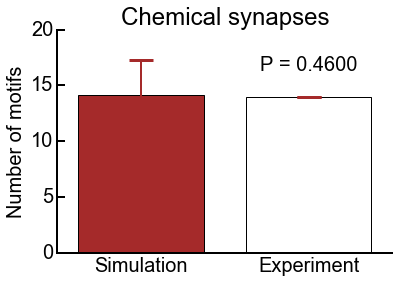

In [42]:
fig = figure(1)
ax = fig.add_subplot(111)

ax = barplot(simulation = n_chem, n_found = mydataset.motif['ii_chem']['found']);
ax.set_title('Chemical synapses');
ax.set_ylim(ymax=20);

fig.savefig('ii_chem.pdf')

<H2>Plot electrical synapses alone </H2>

P = 0.4240


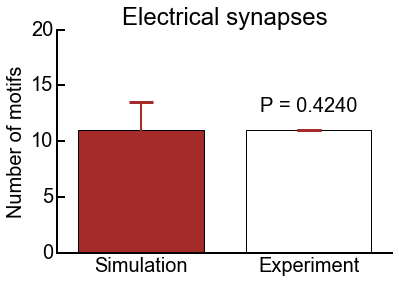

In [43]:
fig = figure(2)
ax = fig.add_subplot(111)

ax = barplot(simulation = n_elec, n_found = mydataset.motif['ii_elec']['found']);
ax.set_title('Electrical synapses');
ax.set_ylim(ymax=20);

fig.savefig('ii_elec.pdf')

<H2>Plot bidirectional chemical synapses</H2>


P = 0.0490


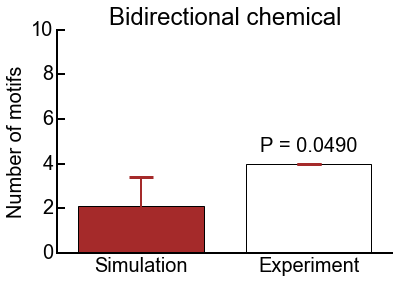

In [44]:
fig = figure(4)
ax = fig.add_subplot(111)

ax = barplot(simulation = n_c2, n_found = mydataset.motif['ii_c2']['found']);
ax.set_title('Bidirectional chemical');
ax.set_ylim(ymax=10);

fig.savefig('ii_c2.pdf')

<H2>Plot electrical and one chemical synapse alone </H2>

P = 0.3200


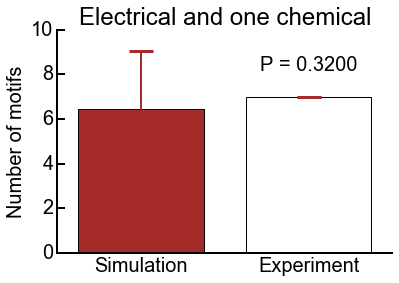

In [45]:
fig = figure(4)
ax = fig.add_subplot(111)

ax = barplot(simulation = n_c1e, n_found = mydataset.motif['ii_c1e']['found']);
ax.set_title('Electrical and one chemical');
ax.set_ylim(ymax=10);

fig.savefig('ii_c1e.pdf')

<H2>Plot electrical and two chemical</H2>

P = 0.0130


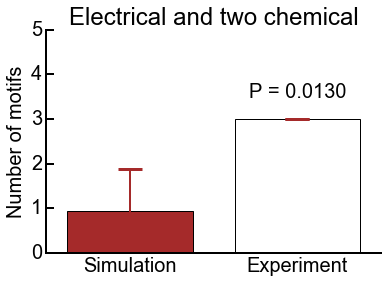

In [46]:
fig = figure(5)
ax = fig.add_subplot(111)

ax = barplot(simulation = n_c2e, n_found = mydataset.motif['ii_c2e']['found']);
ax.set_title('Electrical and two chemical');
ax.set_ylim(ymin  = 0, ymax=5);

fig.savefig('ii_c2d.pdf')